## Conditional Edges: Defining Nodes and a Routing Function

In [1]:
from langgraph.graph import START, END, StateGraph
from typing_extensions import TypedDict
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, BaseMessage
from collections.abc import Sequence
from typing import Literal
import os

### Define the State

In [2]:
class State(TypedDict):
    messages: Sequence[BaseMessage]

### Define the Nodes

In [3]:
os.environ.setdefault("no_proxy", "127.0.0.1,localhost")
os.environ.setdefault("HTTPX_NO_PROXY", "127.0.0.1,localhost")
OLLAMA_URL = os.getenv("OLLAMA_URL", "http://127.0.0.1:11434")

model_name = "gemma3" #"llama3.2:3b"

max_tokens = 100
llm = ChatOllama(model=model_name, num_predict=max_tokens, temperature=0)

In [4]:
def ask_question(state: State) -> State:
    
    print(f"\n-------> ENTERING ask_question:")
    
    print("What is your question?")
    
    return State(messages = [HumanMessage(input())])

In [5]:
ask_question(State(messages = []))


-------> ENTERING ask_question:
What is your question?


{'messages': [HumanMessage(content='1+1=?', additional_kwargs={}, response_metadata={})]}

In [6]:
def chatbot(state: State) -> State:

    print(f"\n-------> ENTERING chatbot:")

    response = llm.invoke(state["messages"])
    response.pretty_print()

    return State(messages = [response])

In [7]:
def ask_another_question(state: State) -> State:
    
    print(f"\n-------> ENTERING ask_another_question:")
    
    print("Would you like to ask one more question (yes/no)?")
    
    return State(messages = [HumanMessage(input())])

In [8]:
ask_another_question(State(messages = []))


-------> ENTERING ask_another_question:
Would you like to ask one more question (yes/no)?


{'messages': [HumanMessage(content='1+2=?', additional_kwargs={}, response_metadata={})]}

### Define the Routing Function

In [9]:
def routing_function(state: State) -> Literal["ask_question", "__end__"]:
    
    if state["messages"][0].content == "yes":
        return "ask_question"
    else:
        return "__end__"

### Define the Graph

In [19]:
graph = StateGraph(State)

In [20]:
graph.add_node("ask_question", ask_question)
graph.add_node("chatbot", chatbot)
graph.add_node("ask_another_question", ask_another_question)

graph.add_edge(START, "ask_question")
graph.add_edge("ask_question", "chatbot")
graph.add_edge("chatbot", "ask_another_question")
graph.add_conditional_edges(source = "ask_another_question", 
                            path = routing_function,
                            path_map = {"True": "ask_question", "False": END})

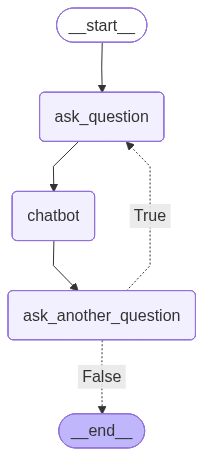

In [21]:
graph_compiled = graph.compile()
graph_compiled

In [22]:
print(graph_compiled.get_graph().draw_ascii())

          +-----------+       
          | __start__ |       
          +-----------+       
                 *            
                 *            
                 *            
         +--------------+     
         | ask_question |     
         +--------------+     
          ***         ..      
         *              ..    
       **                 ..  
+---------+                 . 
| chatbot |               ..  
+---------+             ..    
          ***         ..      
             *      ..        
              **   .          
     +----------------------+ 
     | ask_another_question | 
     +----------------------+ 
                 .            
                 .            
                 .            
            +---------+       
            | __end__ |       
            +---------+       


### Test the Graph

In [31]:
graph_compiled.invoke(State(messages = []))


-------> ENTERING ask_question:
What is your question?

-------> ENTERING chatbot:
================================== Ai Message ==================================

The capital of Iran is **Tehran**. 

It's the country's largest city and political, cultural, and economic center. 

Do you want to know anything more about Tehran or Iran in general?

-------> ENTERING ask_another_question:
Would you like to ask one more question (yes/no)?

-------> ENTERING ask_question:
What is your question?

-------> ENTERING chatbot:
================================== Ai Message ==================================

You haven't asked me any questions yet! This is our first interaction. 😊 

Do you want to ask me something now?

-------> ENTERING ask_another_question:
Would you like to ask one more question (yes/no)?


{'messages': [HumanMessage(content='no', additional_kwargs={}, response_metadata={})]}

In [ ]:
%mypy